#### Name Classification using RNN

In [1]:
# Utils Functions before building the model

import os
import io
import unicodedata
import string
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
ALL_LETTERS = string.ascii_letters + ".,;'"
print(len(ALL_LETTERS))

56


In [3]:
# Turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in ALL_LETTERS)

def load_data():
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)
    
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('./Data/Name Classification/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = read_lines(filename)
        category_lines[category] = lines
    
    return category_lines, all_categories

category_lines, all_categories = load_data()
print(category_lines['Arabic'][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


In [4]:
# Transform the data into tensors

def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, len(ALL_LETTERS))
    tensor[0][letter_to_index(letter_to_tensor)] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, len(ALL_LETTERS))
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

In [5]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.inputTohidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.inputToOutput = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input_tensor, hidden_tensor):
       
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.inputTohidden(combined)
        output  = self.inputToOutput(combined)
        output = self.softmax(output)

        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
# Loading the data

category_lines, all_categories = load_data()
print(f'Number of categories: {len(all_categories)}')

Number of categories: 18


In [7]:
# Instantiate the model

n_letters = len(ALL_LETTERS)
n_categories = len(all_categories)
n_hidden = 128

rnn =  RNN(n_letters, n_hidden, n_categories)

In [8]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

5000 5.0 2.8474 Borovka / Portuguese ✗ (Czech)
10000 10.0 2.8574 Kurohiko / Portuguese ✗ (Japanese)
15000 15.0 2.7782 Schmitz / Polish ✗ (German)
20000 20.0 2.6513 Roche / French ✓
25000 25.0 2.6034 Donnell / Dutch ✗ (Irish)
30000 30.0 3.1325 Odea / Vietnamese ✗ (English)
35000 35.0 1.3112 Niu / Chinese ✓
40000 40.0 3.0279 Casey / Arabic ✗ (Irish)
45000 45.0 3.0259 Zhilin / Arabic ✗ (Russian)
50000 50.0 2.5905 Kasimor / Russian ✗ (Czech)
55000 55.00000000000001 1.8149 Brian / Irish ✓
60000 60.0 2.5750 Kelly / Spanish ✗ (Scottish)
65000 65.0 2.5724 Scott / English ✗ (Scottish)
70000 70.0 0.9135 Jaskulski / Polish ✓
75000 75.0 1.8327 Klerk / Dutch ✓
80000 80.0 3.2432 Kasa / Japanese ✗ (Czech)
85000 85.0 2.5457 Petit / French ✗ (Spanish)
90000 90.0 2.5707 Kehoe / Scottish ✗ (English)
95000 95.0 0.0749 Antonopoulos / Greek ✓
100000 100.0 2.9342 Dubois / Arabic ✗ (French)


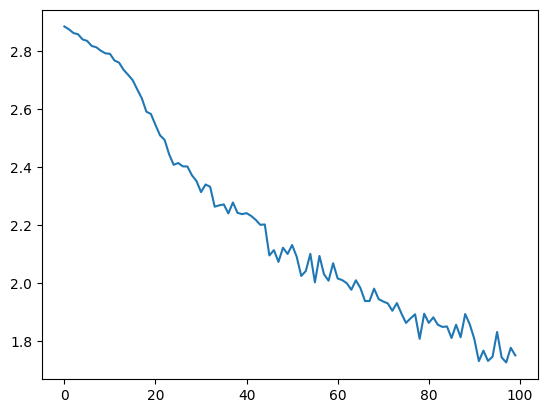

In [9]:
# Training the model

criterion = nn.NLLLoss()
learning_rate = 0.001
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate)

def train(line_tensor, category_tensor):

    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

def random_training_example(category_lines, all_categories):
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


current_loss = 0
all_loss = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if iter % plot_steps == 0:
        all_loss.append(current_loss / plot_steps)
        current_loss = 0
    
    if iter % print_steps == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else f'✗ ({category})'
        print(f'{iter} {iter/n_iters * 100} {loss:.4f} {line} / {guess} {correct}')

plt.figure()
plt.plot(all_loss)
plt.show()

In [11]:
def predict(input_line):
    print(f'\n> {input_line}')
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
            guess = category_from_output(output)
            print(guess)
    

while True:
    sentence = input('Enter a name: ')
    if sentence == 'q':
        break
    predict(sentence)